# Workshop on Statistical Genetics and Genetic Epidemiology STAGE-Quebec
## Theme 2 - Molecular Phenotypes in Genetic Epidemiology

By Marc-André Legault (Université de Montréal) and Qihuang Zhang (McGill University)

**July 31 - August 1, 2025**

### Introduction

In the previous notebook, we conducted TWAS of T2D for 7 GTEx tissues by using the gene expression prediction models from PredictDB and the S-PrediXcan TWAS model. Here, we will explore the results to gain a better understanding of TWAS. Our first task is to summarize the number of significant genes per tissue. So let's first calculate the P-value thresholds

| Tissue               | N tested genes | Global bonferroni | Tissue Bonferroni |
| :------------------: | -------------- | ----------------- | ----------------- |
| Adipose subcutaneous |                |                   |                   |
| ...                  |                |                   |                   |

In [2]:
library(ggplot2)

In [3]:
tissues <- c(
    "en_Adipose_Subcutaneous",
    "en_Artery_Coronary",
    "en_Brain_Cortex",
    "en_Liver",
    "en_Muscle_Skeletal",
    "en_Pancreas",
    "en_Whole_Blood"
)

df <- data.frame()
for (tissue in tissues) {
    cur <- read.csv(paste0("/workshop/local/results/twas_", tissue, ".csv"))
    df <- rbind(df, data.frame(tissue = tissue, n_tested_genes = nrow(cur)))
}

df$global_bonf <- 0.05 / sum(df$n_tested_genes)
df$tissue_bonf <- 0.05 / df$n_tested_genes
df

tissue,n_tested_genes,global_bonf,tissue_bonf
<chr>,<int>,<dbl>,<dbl>
en_Adipose_Subcutaneous,8626,1.174205e-06,5.796429e-06
en_Artery_Coronary,4029,1.174205e-06,1.241003e-05
en_Brain_Cortex,5479,1.174205e-06,9.125753e-06
en_Liver,3765,1.174205e-06,1.328021e-05
en_Muscle_Skeletal,7570,1.174205e-06,6.605020e-06
en_Pancreas,5879,1.174205e-06,8.504848e-06
en_Whole_Blood,7234,1.174205e-06,6.911805e-06


We can see that even a full Bonferroni correction accounting for every test across tissues would be less strict than the genome-wide significance threshold ($5 \times 10^{-8}$). The number of tested tissues is between 3,765 for the liver and 8,626 for subcutaneous adipose tissue which explains why the tissue-specific Bonferroni thresholds may vary. We can look at the number of significant genes depending on the approach. We will also add the Benjamini Hochberg false discovery rate correction.

<div class="alert alert-info">
Why is the number of tested genes vary across tissues?    
</div>

In [4]:
n_sig <- data.frame()
sig_genes_data <- data.frame()
sig_genes <- list()

for (tissue in tissues) {
    cur <- read.csv(paste0("/workshop/local/results/twas_", tissue, ".csv"))

    sig_global_bonf <- cur$pvalue <= 1.174205e-6
    sig_tissue_bonf <- cur$pvalue <= 0.05 / nrow(cur)
    q <- p.adjust(cur$pvalue, method = "BH")
    sig_fdr <- q <= 0.05
    
    sig_genes_data_cur <- cur[sig_fdr, c("gene_name", "pvalue", "effect_size", "n_snps_in_model", "n_snps_used", "pred_perf_pval")]
    sig_genes_data_cur$tissue <- tissue
    sig_genes_data <- rbind(sig_genes_data, sig_genes_data_cur)
    
    sig_genes[[tissue]] <- list(
        sig_global_bonf = cur[sig_global_bonf, "gene_name"],
        sig_tissue_bonf = cur[sig_tissue_bonf, "gene_name"],
        sig_fdr = cur[sig_fdr, "gene_name"]
    )
    
    n_sig <- rbind(n_sig, data.frame(
        tissue = tissue,
        sig_global_bonf = sum(sig_global_bonf),
        sig_tissue_bonf = sum(sig_tissue_bonf),
        sig_fdr = sum(sig_fdr)
    ))
}
n_sig

tissue,sig_global_bonf,sig_tissue_bonf,sig_fdr
<chr>,<int>,<int>,<int>
en_Adipose_Subcutaneous,2,3,5
en_Artery_Coronary,1,2,2
en_Brain_Cortex,0,1,3
en_Liver,0,1,1
en_Muscle_Skeletal,3,4,5
en_Pancreas,4,4,6
en_Whole_Blood,1,1,2


<div class="alert alert-info">
    Which correction is the most strict? The least strict? Which approach is the most appropriate and what the the assumptions of the different methods?
</div>

In [5]:
cat("Significant genes at FDR <= 5% across tissues:\n\n")
for (tissue in tissues) {
    cat(paste0(
        "\t'", tissue, "': ",
        paste0(sig_genes[[tissue]]$sig_fdr, collapse = ", "),
        "\n"
    ))
}

Significant genes at FDR <= 5% across tissues:

	'en_Adipose_Subcutaneous': IRS1, WFS1, JAZF1, AP3S2, KLF14
	'en_Artery_Coronary': JAZF1, AP3S2
	'en_Brain_Cortex': AP3S2, BCAR1, TECTB
	'en_Liver': AP3S2
	'en_Muscle_Skeletal': JAZF1, WFS1, ANK1, AP3S2, FTO
	'en_Pancreas': JAZF1, TH, AP3S2, IRX3, TSSC4, ST6GAL1
	'en_Whole_Blood': CAMK1D, AP3S2


<div class="alert alert-info">
    <p>The genetically predicted expression of <em>AP3S2</em>, in all of the considered tissues, is associated with T2D. For other genes, the effect are only observed in some tissues.</p>
    <p>For example, the expression of FTO is only associated with T2D in skeletal muscle. What could explain this observation?</p>

<!-- Topics of discussion / answers:
- The effect is tissue specific.
- The expression of the gene is only heritable in skeletal muscle.
- There was more power to detect eQTLs or estimate their effect in this tissue.
//-->

</div>

We can visualize the TWAS results using a dot plot to see more information on the TWAS associations, including on the directionality of the effects.

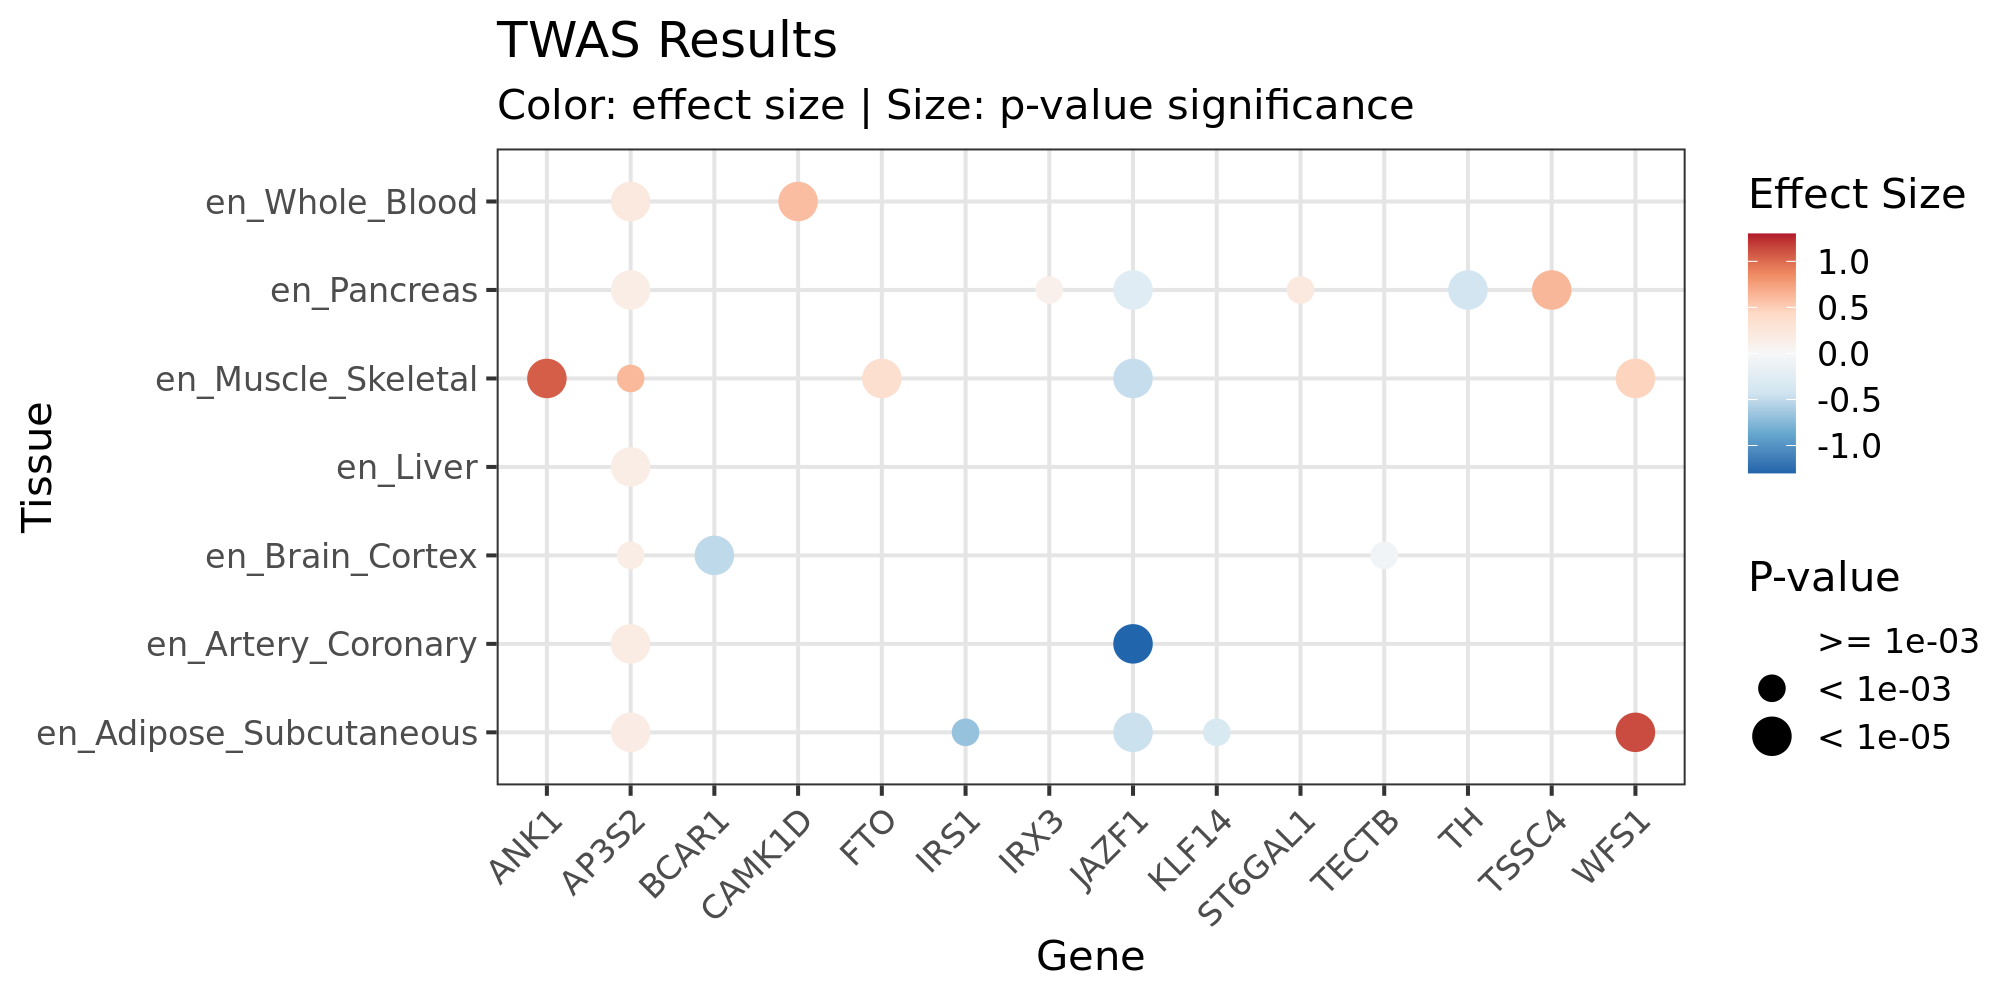

In [6]:
source("/workshop/utilities/gene_tissue_dotplot.R")
options(repr.plot.width = 10, repr.plot.height = 5)
options(repr.plot.res = 200)
plot_gene_tissue_dots_advanced(sig_genes_data)

<div class="alert alert-info">
If we assume that the association is causal, what gene should we inhibit to prevent T2D? In which tissue(s)?
    
<!-- Answer / topics
WFS1 in adipose tissue or ANK1 in muscles could be good choices. We want genes that are positively and robustly associated with T2D (red).
//-->
</div>

We will extract the GWAS summary statistics for the _WFS1_ gene and show the region plot while higlighting the variants included in the prediction model.

In [20]:
# We define the WFS1 region using data from Ensembl.
# See: https://useast.ensembl.org/Homo_sapiens/Gene/Summary?db=core;g=ENSG00000109501;r=4:6269849-6303265
# We added +/- 100kb padding.
wfs1_region <- list(
    chrom = "chr4",
    start = 6269849 - 100000,
    end = 6303265 + 100000
)

get_predictdb_and_gwas_data <- function(region, gene_name, tissue) {
    # We read the GWAS summary statistics, but keep only the information for
    # variants in the region of interest.
    gwas <- read.csv(
        paste0(
            "/workshop/data/PrediXcan/gwas_harmonized/harmonized_",
            tissue,
            ".tsv.gz"
        ), sep="\t"
    )
    gwas_region <- gwas[
        (gwas$chromosome == region$chrom) &
        (region$start <= gwas$base_pair_location) &
        (gwas$base_pair_location <= region$end),
    ]
    rm(gwas)

    # We will extract the rsid and weights of variants included in the
    # gene expression predictive model.
    db_filename = paste0("/workshop/data/PrediXcan/predictdb/", tissue, ".db")
        
    model <- system(paste0(
        "sqlite3 ",
        db_filename,
        " \"select rsid, weight from weights w, extra e where e.gene=w.gene and e.genename='",
        gene_name, "';\""
    ), intern=T)

    if (length(model) == 0) {
        stop("Can't find PredictDB data for gene.")
    }

    model <- data.frame(do.call(rbind, strsplit(model, "\\|")))
    colnames(model) <- c("rsid", "weight")
    model$weight <- as.numeric(model$weight)

    # We create indicator variables to test whether a variant is in the model
    # and we set a default value for the weights for visualization purposes.
    gwas_region$in_model <- gwas_region$rsid_x %in% model$rsid

    gwas_region <- merge(gwas_region, model, by.x = "rsid_x", by.y = "rsid", all.x = T)
    min_abs_weight = min(abs(na.omit(gwas_region$weight)))
    gwas_region$weight <- ifelse(
        is.na(gwas_region$weight),
        0.8 * min_abs_weight,
        gwas_region$weight
    )
    
    list(
        model = model,
        gwas_region = gwas_region
    )
}

plot_region <- function(region, gene_name, tissue) {
    data <- get_predictdb_and_gwas_data(region, gene_name, tissue)
    
    options(repr.plot.width = 10, repr.plot.height = 4)
    options(repr.plot.res = 200)
    
    plot <- ggplot(data$gwas_region, aes(x = base_pair_location, y = neg_log_10_p_value,
                      color = in_model, size = abs(weight))) +
        geom_point(alpha = 0.7) +
        scale_color_manual(values = c("FALSE" = "#222222", "TRUE" = "#2E86C1")) +
        labs(x = paste0("Base pair location (", region$chr, " ,GRCh38)"),
             y = "-log10(P)",
             color = paste0("In ", gene_name, " model")) +
        theme_minimal()
    
    plot
}

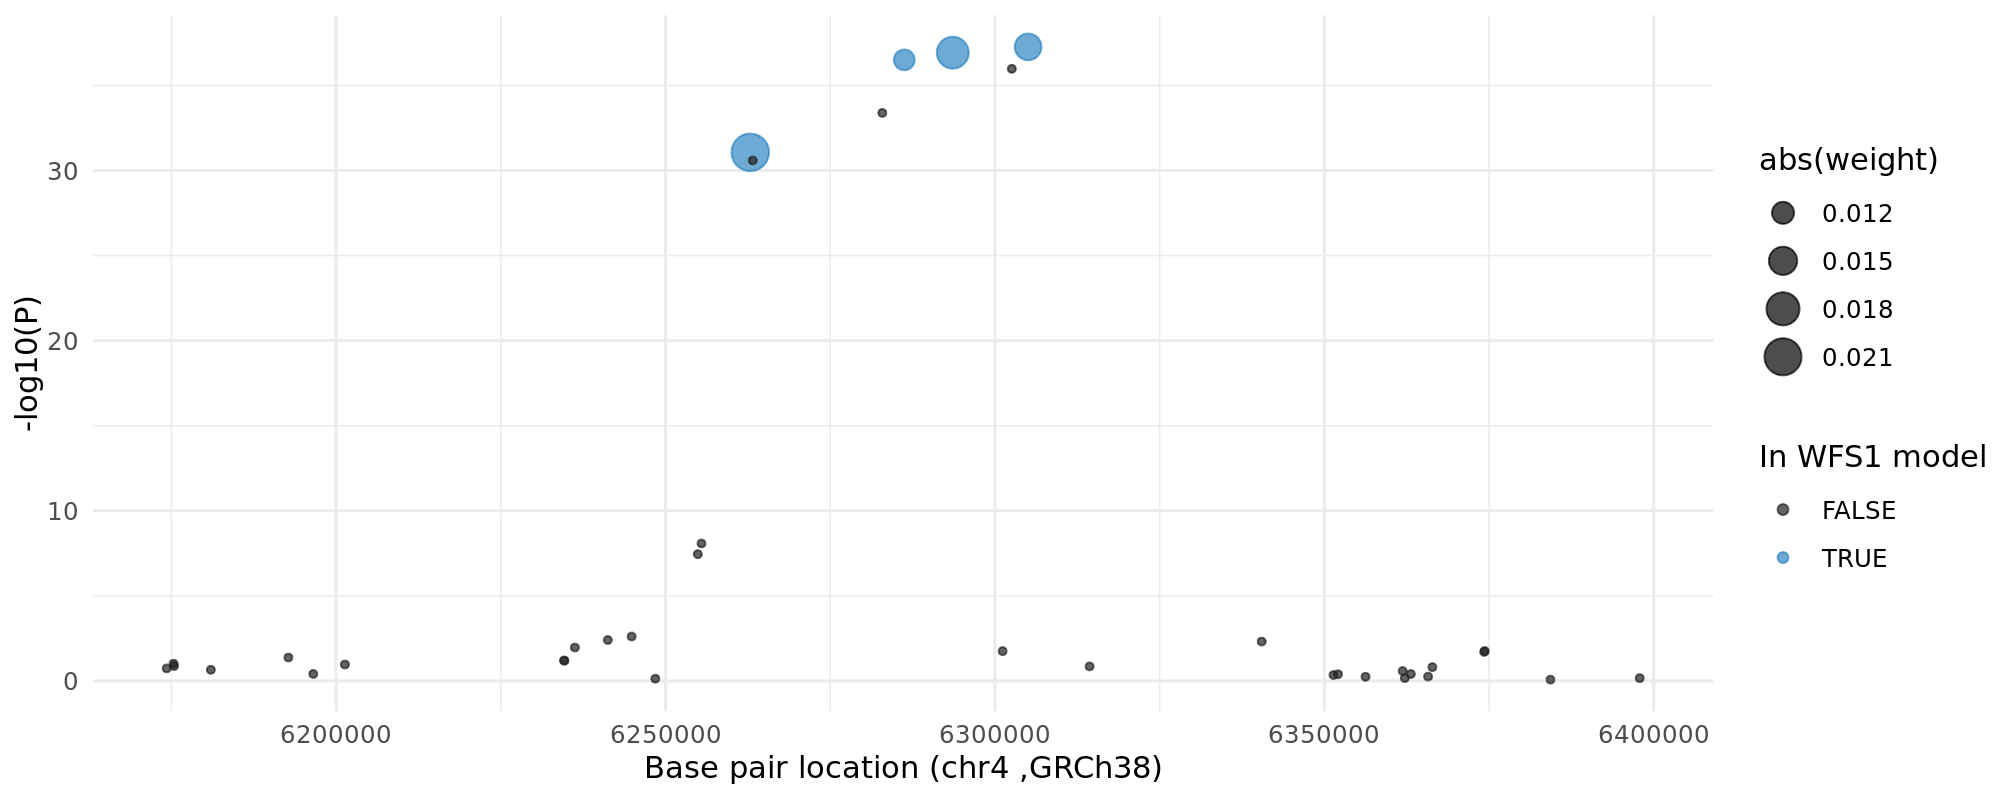

In [21]:
plot_region(wfs1_region, "WFS1", "en_Adipose_Subcutaneous")

<div class="alert alert-info">
    <p>
    The plot above shows the association statistics of genetic variants in the <em>WFS1</em> region with T2D. Blue dots represent variants that were included in the model predicting <em>WFS1</em> expression in adipose tissue, with the size of the dot proportional to the weight.
    </p>
    <p>
    Does this plot support the TWAS results? Can you imagine how this plot could inform the intepretation of the results?
    </p>
    <p>
    Experiment with the following calls to visualize the association signals in other tissues. What do you observe? You can also try the function with other genes!
    </p>
</div>

In [9]:
# plot_region(wfs1_region, "WFS1", "en_Whole_Blood")
# plot_region(wfs1_region, "WFS1", "en_Pancreas")
# plot_region(wfs1_region, "WFS1", "en_Muscle_Skeletal")